In [1]:
#Upload libraries
library(ggplot2)
library(readr)
library(dplyr)
library(ggrepel)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [1]:
# Set the working directory to the parent folder of genomes_download/
# Example:
# setwd("~/microbiota_sialylation/")

In [3]:
#Upload data
accession_list_1 <-  read_delim("genomes_download/plots_data/accession_complete_fields.tsv", 
                                 delim = "\t", escape_double = FALSE, 
                                 trim_ws = TRUE)
head(accession_list_1)
colnames(accession_list_1)

Rows: 2459 Columns: 11
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Assembly Accession, Assembly BioSample Geographic location, Assembl...
dbl (4): Assembly Stats GC Percent, Assembly Stats Total Sequence Length, Or...
lgl (1): Organelle Assembly Name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Assembly Accession,Assembly BioSample Geographic location,Assembly BioSample Host,Assembly BioSample Host disease,Assembly BioSample Isolation source,Assembly Stats GC Percent,Assembly Stats Total Sequence Length,Organelle Assembly Name,Organism Name,Organism Taxonomic ID,Annotation Count Gene Protein-coding
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>
GCF_000007985.2,NA,NA,NA,NA,61.0,3814128,NA,Geobacter sulfurreducens PCA,243231,3405
GCF_000009085.1,NA,NA,NA,NA,30.5,1641481,NA,Campylobacter jejuni subsp. jejuni NCTC 11168 = ATCC 700819,192222,1572
GCF_000009465.1,NA,NA,NA,NA,51.5,2194961,NA,Neisseria meningitidis FAM18,272831,1971
GCF_000012185.1,NA,NA,NA,NA,38.0,1914490,NA,Haemophilus influenzae 86-028NP,281310,1785
GCF_000014105.1,NA,NA,NA,NA,51.5,2153416,NA,Neisseria meningitidis 053442,374833,1909
GCF_000019305.1,NA,NA,NA,NA,28.0,4107013,NA,Clostridium botulinum B1 str. Okra,498213,3741


[1] "Assembly Accession"                    
 [2] "Assembly BioSample Geographic location"
 [3] "Assembly BioSample Host"               
 [4] "Assembly BioSample Host disease"       
 [5] "Assembly BioSample Isolation source"   
 [6] "Assembly Stats GC Percent"             
 [7] "Assembly Stats Total Sequence Length"  
 [8] "Organelle Assembly Name"               
 [9] "Organism Name"                         
[10] "Organism Taxonomic ID"                 
[11] "Annotation Count Gene Protein-coding"

In [4]:
#select columm that I want
select_data <- accession_list_1%>% select('Assembly Accession', 'Assembly BioSample Host', 'Organism Taxonomic ID', 'Organism Name')

#ascending format by Taxonomic ID
select_data_asc <- select_data %>% arrange('Organism Taxonomic ID')

In [5]:
#Preparing data of species to the plot
species_final <-  select_data_asc %>%
  mutate(first_two_words = word(`Organism Name`, 1, 2))%>%
  group_by(first_two_words) %>%             # Group by 'region'
  mutate(species_count = n()) %>%   # Count occurrences and add to new column
  ungroup()                        # Remove grouping



species_final1 <- species_final%>%select(first_two_words, 'species_count')



species_final_unique <- species_final1 %>%
  distinct(first_two_words, .keep_all = TRUE)


head(species_final_unique)


species_final_unique_1 <- species_final_unique %>%
  mutate(perc_species = species_count / sum(species_count) * 100) %>%
  filter(perc_species >= 1.80)

perc_species_round <-round(species_final_unique_1$perc_species, digits = 2)

sum(perc_species_round)

first_two_words,species_count
<chr>,<int>
Geobacter sulfurreducens,3
Campylobacter jejuni,173
Neisseria meningitidis,100
Haemophilus influenzae,95
Clostridium botulinum,50
Glaesserella parasuis,18


[1] 60.02

In [6]:
# Count how many are below threshold
species_below <- species_final_unique %>%
  mutate(perc_species = species_count / sum(species_count) * 100) %>%
  filter(perc_species < 1.80)

# Create the "Others" row
species_others <- species_below %>%
  summarise(
    first_two_words = "Others",
    species_count = sum(species_count)
  ) %>%
  mutate(
    perc_species = species_count / sum(species_final_unique$species_count) * 100
  )


# Combine main data + Others
species_final_unique_2 <- bind_rows(species_final_unique_1, species_others) %>%
  mutate(perc_species = round(perc_species, 2))


In [7]:
#Factor to change legend order
species_final_unique_2$first_two_words <- factor(
  species_final_unique_2$first_two_words
)

levels(species_final_unique_2$first_two_words)

#attribute names
species_final_unique_2$first_two_words  <- factor(species_final_unique_2$first_two_words, levels = c("Campylobacter jejuni","Clostridium botulinum",
                                                                                                     "Escherichia coli","Haemophilus influenzae",
                                                                                                     "Legionella pneumophila","Mannheimia haemolytica",
                                                                                                     "Neisseria meningitidis","Pasteurella multocida",
                                                                                                     "Streptococcus agalactiae","Streptococcus suis",
                                                                                                     "Streptomyces sp.", "Others"))

#create color pallette
color_pallete_graph <- c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#7570B3','#f781bf',  '#66c2a5', '#fc8d62', '#999999')

[1] "Campylobacter jejuni"     "Clostridium botulinum"   
 [3] "Escherichia coli"         "Haemophilus influenzae"  
 [5] "Legionella pneumophila"   "Mannheimia haemolytica"  
 [7] "Neisseria meningitidis"   "Others"                  
 [9] "Pasteurella multocida"    "Streptococcus agalactiae"
[11] "Streptococcus suis"       "Streptomyces sp."

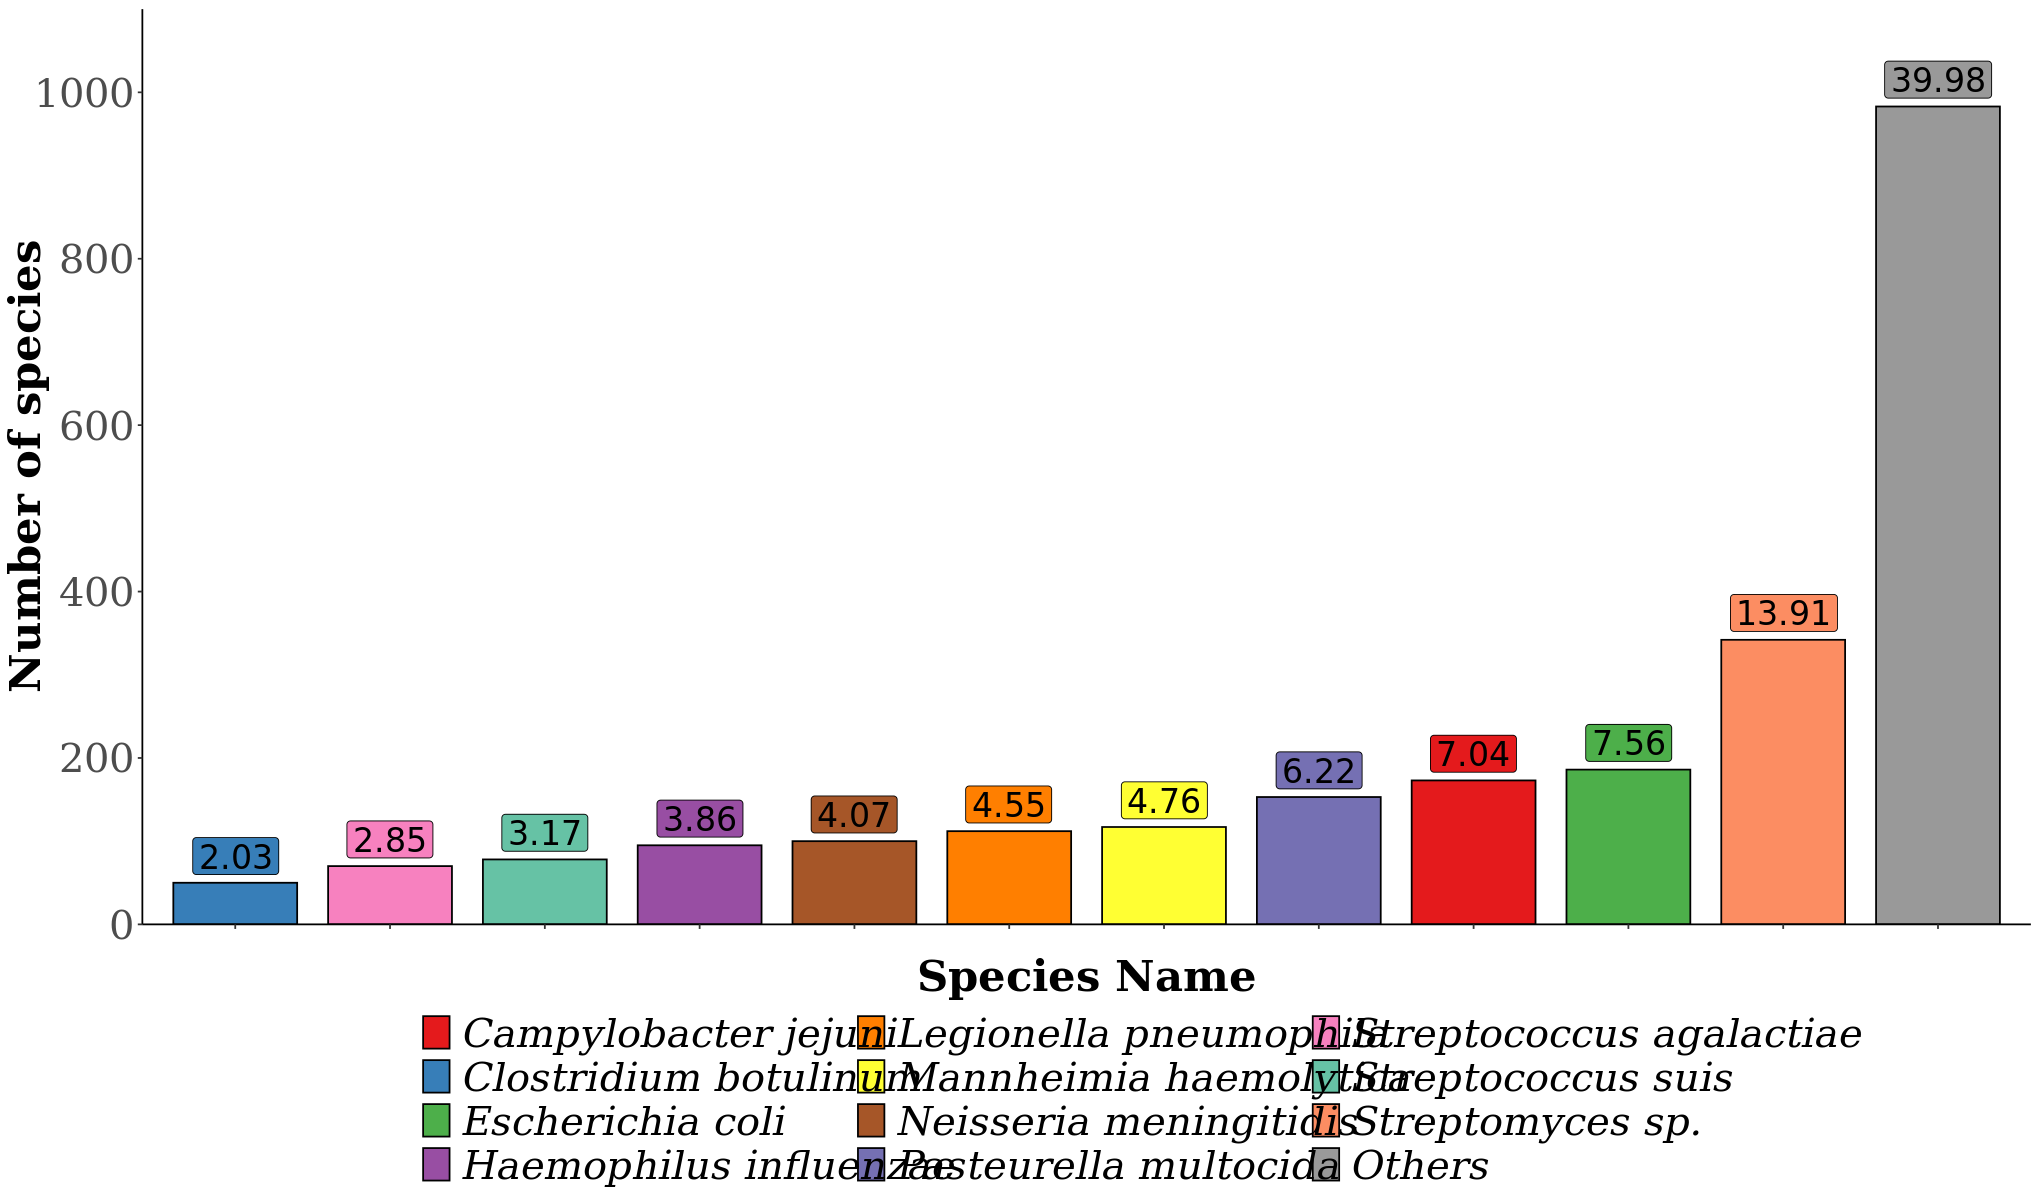

In [11]:
#create chart
f <- ggplot(species_final_unique_2, 
       aes(x =  reorder(first_two_words, perc_species), 
           y = species_count, 
           fill = first_two_words)) +
   geom_bar(stat = "identity", color = "black", width = 0.8) +
  geom_label_repel(
    aes(label = perc_species),
    color = "black",
    nudge_y = 3,         # moves labels upward
    show.legend = FALSE,
    box.padding = 0.3,
    size = 7,
    segment.color = "black", max.overlaps = Inf
  ) +
  scale_fill_manual(values = color_pallete_graph) +
  labs(
    x = "Species Name",
    y = "Number of species",
    fill = "Species Name"
  ) + guides(
    fill = guide_legend(title.hjust = 0.5,
      title.position = "top", ncol = 3)) +
  theme_classic(base_family = "Times")+
  theme(legend.position = "bottom",
              legend.text  = element_text(size = 24, family = "Times", face = "italic"),
        legend.spacing.x = unit(2, "cm"),
              legend.title = element_text(size = 26, family = "Times", face = "bold",  margin = margin(b = 12)),
    axis.text.x =  element_blank(),
    axis.text.y = element_text(size = 24, family = "Times"),
    axis.title.y = element_text(size = 26, family = "Times", face = "bold"),
    axis.title.x =  element_blank()
  ) + scale_y_continuous(expand = expansion(), breaks = c(0,200,400,600,800,1000), limits = c(0,1100))

options(repr.plot.width = 17, repr.plot.height = 10)
print(f)